In [1]:
!pip install langchain langgraph langchain-openai faiss-cpu

In [2]:
from google.colab import userdata
from dotenv import load_dotenv
load_dotenv()

# Get the API key from environment variables
openai_api_key = userdata.get("OPENAI_API_KEY")
import os
os.environ["OPENAI_API_KEY"] = openai_api_key

In [3]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large"
)


In [4]:
!pip install langchain_community

In [5]:
#from langchain.vectorstores import FAISS
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document

#from langchain.schema import Document

docs = [
    Document(page_content="High engine temperature may indicate coolant leak or radiator failure."),
    Document(page_content="Low battery voltage often suggests battery degradation."),
    Document(page_content="Brake pressure loss is usually caused by hydraulic fluid leakage."),
    Document(page_content="Brake system faults are safety critical and require immobilization.")
]

vectorstore = FAISS.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})


In [6]:
from typing import TypedDict, List, Dict

class VehicleState(TypedDict):
    vehicle_id: str
    telemetry: Dict[str, float]
    anomaly: str
    retrieved_docs: List[str]
    diagnosis: str
    decision: str


In [7]:
def telemetry_node(state: VehicleState):
    return state


In [8]:
def anomaly_node(state: VehicleState):
    t = state["telemetry"]

    if t["engine_temp"] > 110:
        state["anomaly"] = "High engine temperature"
    elif t["battery_voltage"] < 11.5:
        state["anomaly"] = "Low battery voltage"
    elif t["brake_pressure"] < 20:
        state["anomaly"] = "Brake pressure loss"
    else:
        state["anomaly"] = "Normal"

    return state


In [9]:
def retrieval_node(state: VehicleState):
    docs = retriever.invoke(state["anomaly"])
    state["retrieved_docs"] = [d.page_content for d in docs]
    return state


In [10]:
def diagnosis_node(state: VehicleState):
    context = "\n".join(state["retrieved_docs"])

    prompt = f"""
    You are an automotive diagnostics expert.

    Telemetry:
    {state["telemetry"]}

    Detected anomaly:
    {state["anomaly"]}

    Relevant knowledge:
    {context}

    Identify the most likely root cause.
    """

    response = llm.invoke(prompt)
    state["diagnosis"] = response.content
    return state


In [11]:
def decision_node(state: VehicleState):
    prompt = f"""
    You are a fleet safety AI.

    Diagnosis:
    {state["diagnosis"]}

    Decide the safest action.
    Constraints:
    - Human safety first
    - Vehicle protection second
    - Cost last

    Respond with ONE action.
    """

    response = llm.invoke(prompt)
    state["decision"] = response.content
    return state


In [12]:
def report_node(state: VehicleState):
    print("\n===== VEHICLE INCIDENT REPORT =====")
    print("Vehicle ID:", state["vehicle_id"])
    print("Telemetry:", state["telemetry"])
    print("Anomaly:", state["anomaly"])
    print("Diagnosis:", state["diagnosis"])
    print("Decision:", state["decision"])
    print("=================================\n")

    return state


In [13]:
from langgraph.graph import StateGraph, END

graph = StateGraph(VehicleState)

graph.add_node("telemetry", telemetry_node)
graph.add_node("anomaly", anomaly_node)
graph.add_node("retrieve", retrieval_node)
graph.add_node("diagnose", diagnosis_node)
graph.add_node("decide", decision_node)
graph.add_node("report", report_node)

graph.set_entry_point("telemetry")

graph.add_edge("telemetry", "anomaly")
graph.add_edge("anomaly", "retrieve")
graph.add_edge("retrieve", "diagnose")
graph.add_edge("diagnose", "decide")
graph.add_edge("decide", "report")
graph.add_edge("report", END)

app = graph.compile()


In [14]:
initial_state = {
    "vehicle_id": "CAR-9001",
    "telemetry": {
        "engine_temp": 128,
        "battery_voltage": 12.1,
        "brake_pressure": 30
    },
    "anomaly": "",
    "retrieved_docs": [],
    "diagnosis": "",
    "decision": ""
}

app.invoke(initial_state)



===== VEHICLE INCIDENT REPORT =====
Vehicle ID: CAR-9001
Telemetry: {'engine_temp': 128, 'battery_voltage': 12.1, 'brake_pressure': 30}
Anomaly: High engine temperature
Diagnosis: Based on the telemetry data and the detected anomaly of high engine temperature, the most likely root cause is related to the cooling system. The engine temperature of 128 (assuming this is in degrees Celsius) is significantly higher than normal operating temperatures, which typically range from 90 to 105 degrees Celsius for most vehicles.

Given the relevant knowledge, the high engine temperature could be due to:

1. **Coolant Leak**: A coolant leak would reduce the amount of coolant available to absorb and dissipate heat from the engine, leading to an increase in engine temperature.

2. **Radiator Failure**: If the radiator is not functioning properly, it will not be able to effectively cool the coolant, resulting in higher engine temperatures.

While the brake system fault is mentioned as safety-critical,

{'vehicle_id': 'CAR-9001',
 'telemetry': {'engine_temp': 128,
  'battery_voltage': 12.1,
  'brake_pressure': 30},
 'anomaly': 'High engine temperature',
 'retrieved_docs': ['High engine temperature may indicate coolant leak or radiator failure.',
  'Brake system faults are safety critical and require immobilization.'],
 'diagnosis': 'Based on the telemetry data and the detected anomaly of high engine temperature, the most likely root cause is related to the cooling system. The engine temperature of 128 (assuming this is in degrees Celsius) is significantly higher than normal operating temperatures, which typically range from 90 to 105 degrees Celsius for most vehicles.\n\nGiven the relevant knowledge, the high engine temperature could be due to:\n\n1. **Coolant Leak**: A coolant leak would reduce the amount of coolant available to absorb and dissipate heat from the engine, leading to an increase in engine temperature.\n\n2. **Radiator Failure**: If the radiator is not functioning prope

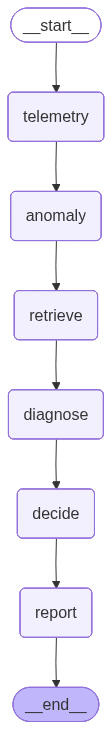

In [15]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))